In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

%reload_ext autoreload
%autoreload 2 

### Loading the experiment scores

In [2]:

filenames = [
  'results_cnwheat_delay_line.csv',
  'results_cnwheat_polynomial.csv',
  'results_cnwheat_NARMA.csv',
  'results_cnwheat_future.csv',
]

# data = pd.read_csv(filename, index_col=0)
dfs = [pd.read_csv(f, index_col=0) for f in filenames]
data = pd.concat(dfs, axis=0, ignore_index=True)

targets = data['target_id'].unique().tolist()
reservoirs = data['reservoir_id'].unique().tolist()
datasets = data['dataset_id'].unique().tolist()
benchmarks = data['benchmark'].unique().tolist()

data = data.set_index(['target_id', 'reservoir_id', 'benchmark'])
data = data.sort_values(['target_id', 'reservoir_id', 'benchmark'], axis=0)

print(f'Available benchmark data: {benchmarks}')

Available benchmark data: ['delay_line', 'polynomial', 'NARMA', 'near_future_pred']


In [3]:
benchmarks = ['delay_line', 'near_future_pred', 'polynomial', 'NARMA']

bench_param = {
  'delay_line': 'delay',
  'near_future_pred': 'lookahead',
  'polynomial': 'exponent',
  'NARMA': 'narma_n',
}

bench_title = {
  'delay_line': 'Delay line prediction',
  'near_future_pred': 'Near-future prediction',
  'polynomial': 'Polynomial transformation',
  'NARMA': 'NARMA benchmark',
}

bench_xlabel = {
  'delay_line': 'Delay (h)',
  'near_future_pred': 'Lookahead (h)',
  'polynomial': 'Polynomial exponent',
  'NARMA': '$n$ parameter',
}

### Prefilter data

In [29]:
from model_config_cnwheat import (input_targets, input_symbols, input_names, state_variables,
   measurable_reservoirs, state_names, state_units, state_symbols)

STATE_VARIABLES = measurable_reservoirs

### Visualizations

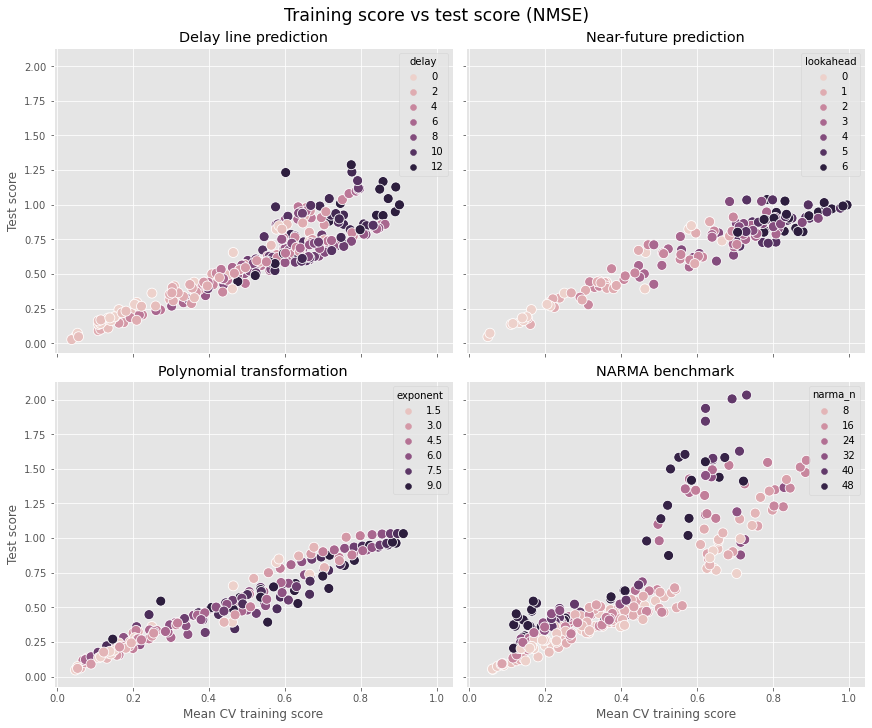

In [16]:
with plt.style.context('ggplot'):
  fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True, sharey=True, sharex=True)

  for benchmark, ax in zip(benchmarks, axs.flatten()):

    plot_data = data.loc[input_targets, STATE_VARIABLES, benchmark].reset_index()
    plot_data['test_score'] *= -1
    plot_data['train_mean'] *= -1
    sns.scatterplot(x='train_mean', y='test_score', hue=bench_param[benchmark], s=100, data=plot_data, ax=ax)
    ax.set_title(f'{bench_title[benchmark]}')
    ax.set_xlabel('Mean CV training score')
    ax.set_ylabel('Test score')

  fig.suptitle('Training score vs test score (NMSE)', fontsize='xx-large')

### Delay line 

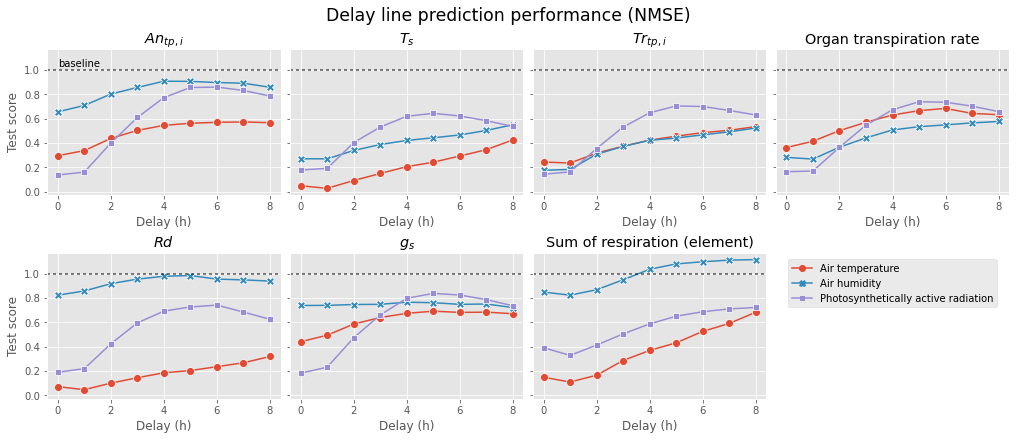

In [39]:
BENCHMARK = 'delay_line'
TARGETS = input_targets
MAX_PARAM = 8


res_to_title = lambda x: f'{state_symbols[x]}'
# res_to_title = lambda x: x.replace("_", " ").replace("  ", " ").replace("state", "[STATE]").replace("env", "[ENV]")

with plt.style.context('ggplot'):
  reservoirs = STATE_VARIABLES
  n_cols = 4
  n_rows = int(np.ceil(len(reservoirs) / n_cols))

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False, constrained_layout=True, sharey=True, sharex=False)

  for reservoir, ax in zip(reservoirs, axs.flatten()):

    plot_data = data.loc[TARGETS, reservoir, BENCHMARK].reset_index()
    plot_data = plot_data[plot_data[bench_param[BENCHMARK]] <= MAX_PARAM]
    plot_data['test_score'] *= -1

    sns.lineplot(x=bench_param[BENCHMARK], y="test_score", hue="target_id", style="target_id",
                 dashes=False, markers=True, data=plot_data, ax=ax, markersize=8)


    ax.axhline(1, dashes=(2, 2), color='black', alpha=0.66)
    if ax is axs[0, 0]:
      ax.text(0, 1.025, 'baseline', fontsize='medium', rotation='horizontal')


    x_ticks = plot_data[bench_param[BENCHMARK]].unique().tolist()
    ax.set_xticks(x_ticks[::2])

    if ax is axs[0, 0]:
      handles, labels = ax.get_legend_handles_labels()
      labels = [input_names[l] for l in labels]
      fig.legend(handles, labels, bbox_to_anchor=(0.99, 0.42))
    ax.legend_.remove()

    ax.set_xlabel(bench_xlabel[BENCHMARK])
    ax.set_ylabel("Test score")
    ax.set_title(f'{res_to_title(reservoir)}')

  for ax in axs.flatten()[len(reservoirs):]:
    ax.remove()

  plt.suptitle(f'{bench_title[BENCHMARK]} performance (NMSE)', fontsize='xx-large')

### Future prediction

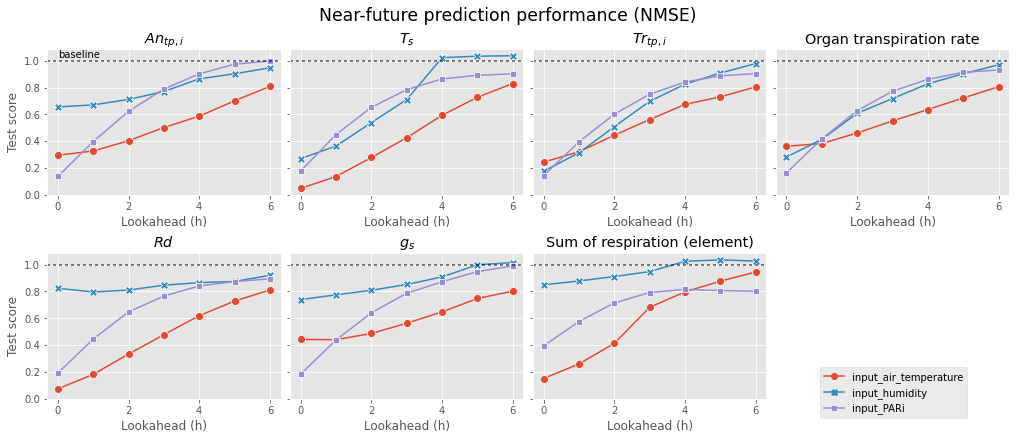

In [18]:
BENCHMARK = 'near_future_pred'
TARGETS = input_targets

MAX_PARAM = 8

res_to_title = lambda x: f'{state_symbols[x]}'
# res_to_title = lambda x: x.replace("_", " ").replace("  ", " ").replace("state", "[STATE]").replace("env", "[ENV]")

with plt.style.context('ggplot'):
  reservoirs = STATE_VARIABLES
  n_cols = 4
  n_rows = int(np.ceil(len(reservoirs) / n_cols))

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False, constrained_layout=True, sharey=True, sharex=False)

  for reservoir, ax in zip(reservoirs, axs.flatten()):

    plot_data = data.loc[TARGETS, reservoir, BENCHMARK].reset_index()
    plot_data = plot_data[plot_data[bench_param[BENCHMARK]] <= MAX_PARAM]
    plot_data['test_score'] *= -1

    sns.lineplot(x=bench_param[BENCHMARK], y="test_score", hue="target_id", style="target_id",
                 dashes=False, markers=True, data=plot_data, ax=ax, markersize=8)


    ax.axhline(1, dashes=(2, 2), color='black', alpha=0.66)
    if ax is axs[0, 0]:
      ax.text(0, 1.025, 'baseline', fontsize='medium', rotation='horizontal')


    x_ticks = plot_data[bench_param[BENCHMARK]].unique().tolist()
    ax.set_xticks(x_ticks[::2])

    if ax is axs[0, 0]:
      handles, labels = ax.get_legend_handles_labels()
      fig.legend(handles, labels, bbox_to_anchor=(0.99, 0.42))
    ax.legend_.remove()

    ax.set_xlabel(bench_xlabel[BENCHMARK])
    ax.set_ylabel("Test score")
    ax.set_title(f'{res_to_title(reservoir)}')

  for ax in axs.flatten()[len(reservoirs):]:
    ax.remove()

  plt.suptitle(f'{bench_title[BENCHMARK]} performance (NMSE)', fontsize='xx-large')

### Polynomial transform

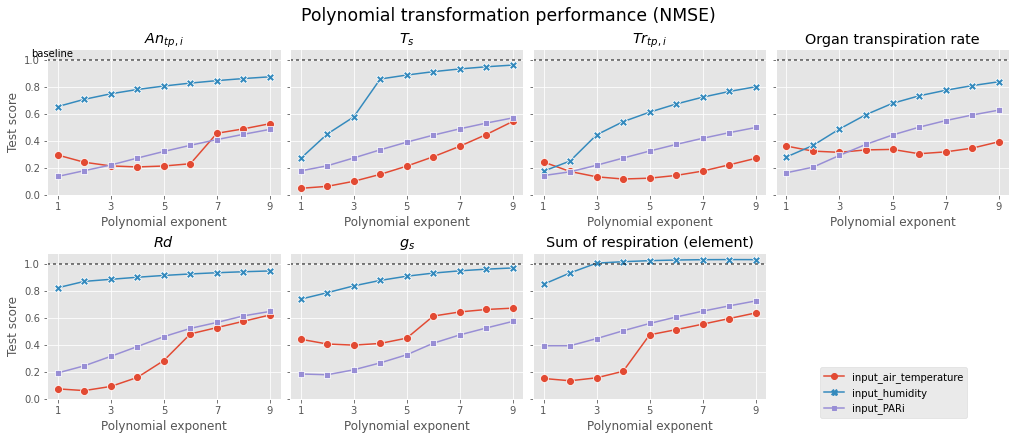

In [19]:
BENCHMARK = 'polynomial'
TARGETS = input_targets

MAX_PARAM = 100

res_to_title = lambda x: f'{state_symbols[x]}'

with plt.style.context('ggplot'):
  reservoirs = STATE_VARIABLES
  n_cols = 4
  n_rows = int(np.ceil(len(reservoirs) / n_cols))

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False, constrained_layout=True, sharey=True, sharex=False)

  for reservoir, ax in zip(reservoirs, axs.flatten()):

    plot_data = data.loc[TARGETS, reservoir, BENCHMARK].reset_index()
    plot_data = plot_data[plot_data[bench_param[BENCHMARK]] <= MAX_PARAM]
    plot_data['test_score'] *= -1

    sns.lineplot(x=bench_param[BENCHMARK], y="test_score", hue="target_id", style="target_id",
                 dashes=False, markers=True, data=plot_data, ax=ax, markersize=8)


    ax.axhline(1, dashes=(2, 2), color='black', alpha=0.66)
    if ax is axs[0, 0]:
      ax.text(0, 1.025, 'baseline', fontsize='medium', rotation='horizontal')


    x_ticks = plot_data[bench_param[BENCHMARK]].unique().tolist()
    ax.set_xticks(x_ticks[::2])

    if ax is axs[0, 0]:
      handles, labels = ax.get_legend_handles_labels()
      fig.legend(handles, labels, bbox_to_anchor=(0.96, 0.17))
    ax.legend_.remove()

    ax.set_xlabel(bench_xlabel[BENCHMARK])
    ax.set_ylabel("Test score")
    ax.set_title(f'{res_to_title(reservoir)}')

  for ax in axs.flatten()[len(reservoirs):]:
    ax.remove()

  plt.suptitle(f'{bench_title[BENCHMARK]} performance (NMSE)', fontsize='xx-large')

### NARMA

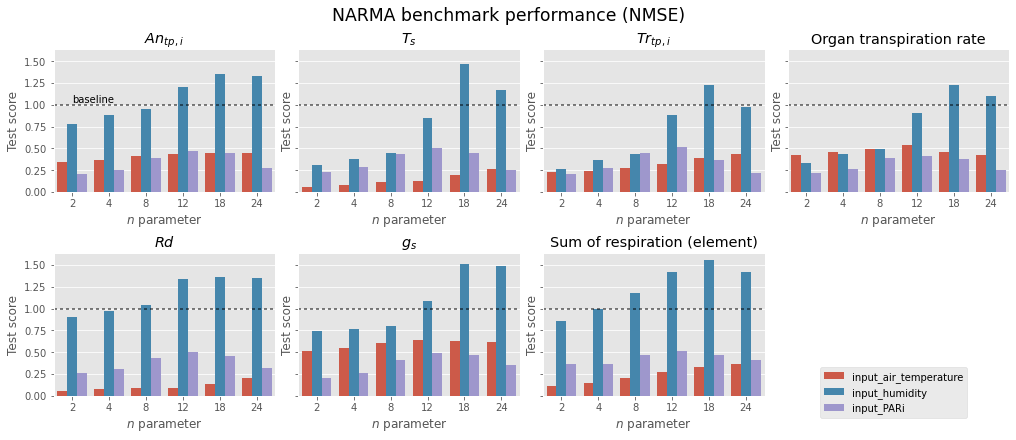

In [20]:
BENCHMARK = 'NARMA'
TARGETS = input_targets
PARAMS = [2, 4, 8, 12, 18, 24]


res_to_title = lambda x: f'{state_symbols[x]}'

with plt.style.context('ggplot'):
  n_cols = 4
  n_rows = int(np.ceil(len(reservoirs) / n_cols))
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False, constrained_layout=True, sharey=True, sharex=False)

  for reservoir, ax in zip(reservoirs, axs.flatten()):
    plot_data = data.loc[TARGETS, reservoir, BENCHMARK].reset_index()
    plot_data = plot_data[plot_data[bench_param[BENCHMARK]].isin(PARAMS)]
    plot_data['test_score'] *= -1

    # plot data
    sns.barplot(x=bench_param[BENCHMARK], y="test_score", hue="target_id",  data=plot_data, ax=ax)

    # plot baseline score dashed line
    ax.axhline(1, dashes=(2, 2), color='black', alpha=0.66)
    if ax is axs[0, 0]:
      ax.text(0, 1.025, 'baseline', fontsize='medium', rotation='horizontal')

    # Legend
    if ax is axs[0, 0]:
      handles, labels = ax.get_legend_handles_labels()
      fig.legend(handles, labels, bbox_to_anchor=(0.96, 0.17))
    ax.legend_.remove()

    # Annotate subfigure
    x_ticks = plot_data[bench_param[BENCHMARK]].unique().tolist()
    ax.set_xticklabels([int(x) for x in x_ticks])
    ax.set_xlabel(bench_xlabel[BENCHMARK])
    ax.set_ylabel("Test score")
    ax.set_title(f'{res_to_title(reservoir)}')

  for ax in axs.flatten()[len(reservoirs):]:
    ax.remove()

  plt.suptitle(f'{bench_title[BENCHMARK]} performance (NMSE)', fontsize='xx-large')